# Edge AI Anomaly Detection

## Overview

This document contains the code for our EclipseCON 2022 Talk: "_How to Train Your Dragon and Its Friends: AI on the Edge with Eclipse Kura&trade;_"

In this notebook we'll cover:
- **Data collection**: how to retrieve training data from the field leveragin Eclipse Kura&trade; and Eclipse Kapua&trade;
- **Data exploration**: how to explore our training data and manipulate them to make them suitable for training
- **Model training**: how we can create a simple Autoencoder in Keras and how to train it
- **Model performance evaluation**: how can we ensure the model was trained correctly
- **Model conversion**: how we can convert the model to make it suitable for running on Eclipse Kura&trade; and Nvidia Triton&trade;
- **Model deployment**: how can we deploy our model on our final device and use it for real-time anomaly detection

## Data collection

[WIP]

## Data Exploration

We can now work on our `.csv` file downloaded from Kapua. For demonstration purposes a copy is provided within this repository.

In [4]:
!ls *.csv

train-data-raw.csv


Let's start taking a look at the content of this dataset, we'll use [pandas](https://pandas.pydata.org/) (Python Data Analysis library) for this.

In [10]:
import pandas as pd

train_data = pd.read_csv("./train-data-raw.csv")

train_data.head()

,ID,TIMESTAMP,MAGNET_X,TEMP_HUM_timestamp,MAGNET_Z,MAGNET_Y,ACC_Y,ACC_X,GYRO_Y_timestamp,ACC_Z,...,PRESSURE_timestamp,MAGNET_X_timestamp,ACC_X_timestamp,GYRO_Z_timestamp,HUMIDITY_timestamp,assetName,ACC_Z_timestamp,GYRO_X,GYRO_Y,GYRO_Z
0,1,1645778791786,-2.680372,1645778791413,5.036951,8.646852,0.004364,0.080122,1645778791413,0.984048,...,1645778791413,1645778791413,1645778791413,1645778791413,1645778791413,asset-sensehat,1645778791413,0.053243,0.028920,0.036950
1,2,1645778792381,-3.110756,1645778792378,5.952562,10.521458,0.005091,0.080122,1645778792378,0.992090,...,1645778792378,1645778792378,1645778792378,1645778792378,1645778792378,asset-sensehat,1645778792378,-0.051105,-0.028920,-0.037256
2,3,1645778793412,-3.482263,1645778793408,6.719675,11.944528,0.005334,0.080122,1645778793408,0.986729,...,1645778793408,1645778793408,1645778793408,1645778793408,1645778793408,asset-sensehat,1645778793408,-0.025253,0.025560,0.038478
3,4,1645778794411,-3.813552,1645778794407,7.375115,13.093461,0.006061,0.080122,1645778794407,0.990384,...,1645778794407,1645778794407,1645778794407,1645778794407,1645778794407,asset-sensehat,1645778794407,0.100695,-0.023422,-0.037867
4,5,1645778795411,-4.050513,1645778795407,7.854155,14.029530,0.004849,0.080607,1645778795407,0.988922,...,1645778795407,1645778795407,1645778795407,1645778795407,1645778795407,asset-sensehat,1645778795407,-0.100389,0.021895,0.038172


In [11]:
train_data.describe()

,ID,TIMESTAMP,MAGNET_X,TEMP_HUM_timestamp,MAGNET_Z,MAGNET_Y,ACC_Y,ACC_X,GYRO_Y_timestamp,ACC_Z,...,MAGNET_Z_timestamp,PRESSURE_timestamp,MAGNET_X_timestamp,ACC_X_timestamp,GYRO_Z_timestamp,HUMIDITY_timestamp,ACC_Z_timestamp,GYRO_X,GYRO_Y,GYRO_Z
count,25278.000000,2.527800e+04,25278.000000,2.527800e+04,25278.000000,25278.000000,25278.000000,25278.000000,2.527800e+04,25278.000000,...,2.527800e+04,2.527800e+04,2.527800e+04,2.527800e+04,2.527800e+04,2.527800e+04,2.527800e+04,25278.000000,25278.000000,25278.000000
mean,12639.500000,1.645807e+12,-8.447224,1.645807e+12,9.319494,17.033101,0.003544,0.085134,1.645807e+12,0.989769,...,1.645807e+12,1.645807e+12,1.645807e+12,1.645807e+12,1.645807e+12,1.645807e+12,1.645807e+12,-0.002612,-0.000896,-0.000403
std,7297.274388,5.246846e+07,1.571525,5.246846e+07,1.267257,1.031078,0.011132,0.003027,5.246846e+07,0.013210,...,5.246846e+07,5.246846e+07,5.246846e+07,5.246846e+07,5.246846e+07,5.246846e+07,5.246846e+07,0.242927,0.032771,0.013528
min,1.000000,1.645779e+12,-14.747911,1.645779e+12,2.510602,2.819213,-0.132551,-0.049693,1.645779e+12,0.759847,...,1.645779e+12,1.645779e+12,1.645779e+12,1.645779e+12,1.645779e+12,1.645779e+12,1.645779e+12,-1.937896,-0.265019,-0.250647
25%,6320.250000,1.645785e+12,-8.683116,1.645785e+12,8.314631,16.399994,0.002182,0.083763,1.645785e+12,0.987460,...,1.645785e+12,1.645785e+12,1.645785e+12,1.645785e+12,1.645785e+12,1.645785e+12,1.645785e+12,-0.001888,-0.001277,-0.000944
50%,12639.500000,1.645798e+12,-8.162970,1.645798e+12,9.315200,16.797381,0.003637,0.084977,1.645798e+12,0.990140,...,1.645798e+12,1.645798e+12,1.645798e+12,1.645798e+12,1.645798e+12,1.645798e+12,1.645798e+12,0.000019,-0.000103,-0.000043
75%,18958.750000,1.645808e+12,-7.686532,1.645808e+12,10.204106,17.253621,0.005334,0.086434,1.645808e+12,0.991846,...,1.645808e+12,1.645808e+12,1.645808e+12,1.645808e+12,1.645808e+12,1.645808e+12,1.645808e+12,0.002204,0.001007,0.000779
max,25278.000000,1.646036e+12,-0.608070,1.646036e+12,13.247377,20.564764,0.093099,0.150289,1.646036e+12,1.177543,...,1.646036e+12,1.646036e+12,1.646036e+12,1.646036e+12,1.646036e+12,1.646036e+12,1.646036e+12,1.923712,0.219204,0.671759


As you can see we can already spot a few entries we don't care about: `ID` and sensor's timestamps are not relevant for us so we can get rid of them and focus on the remaining features.

This process is called **feature selection**.

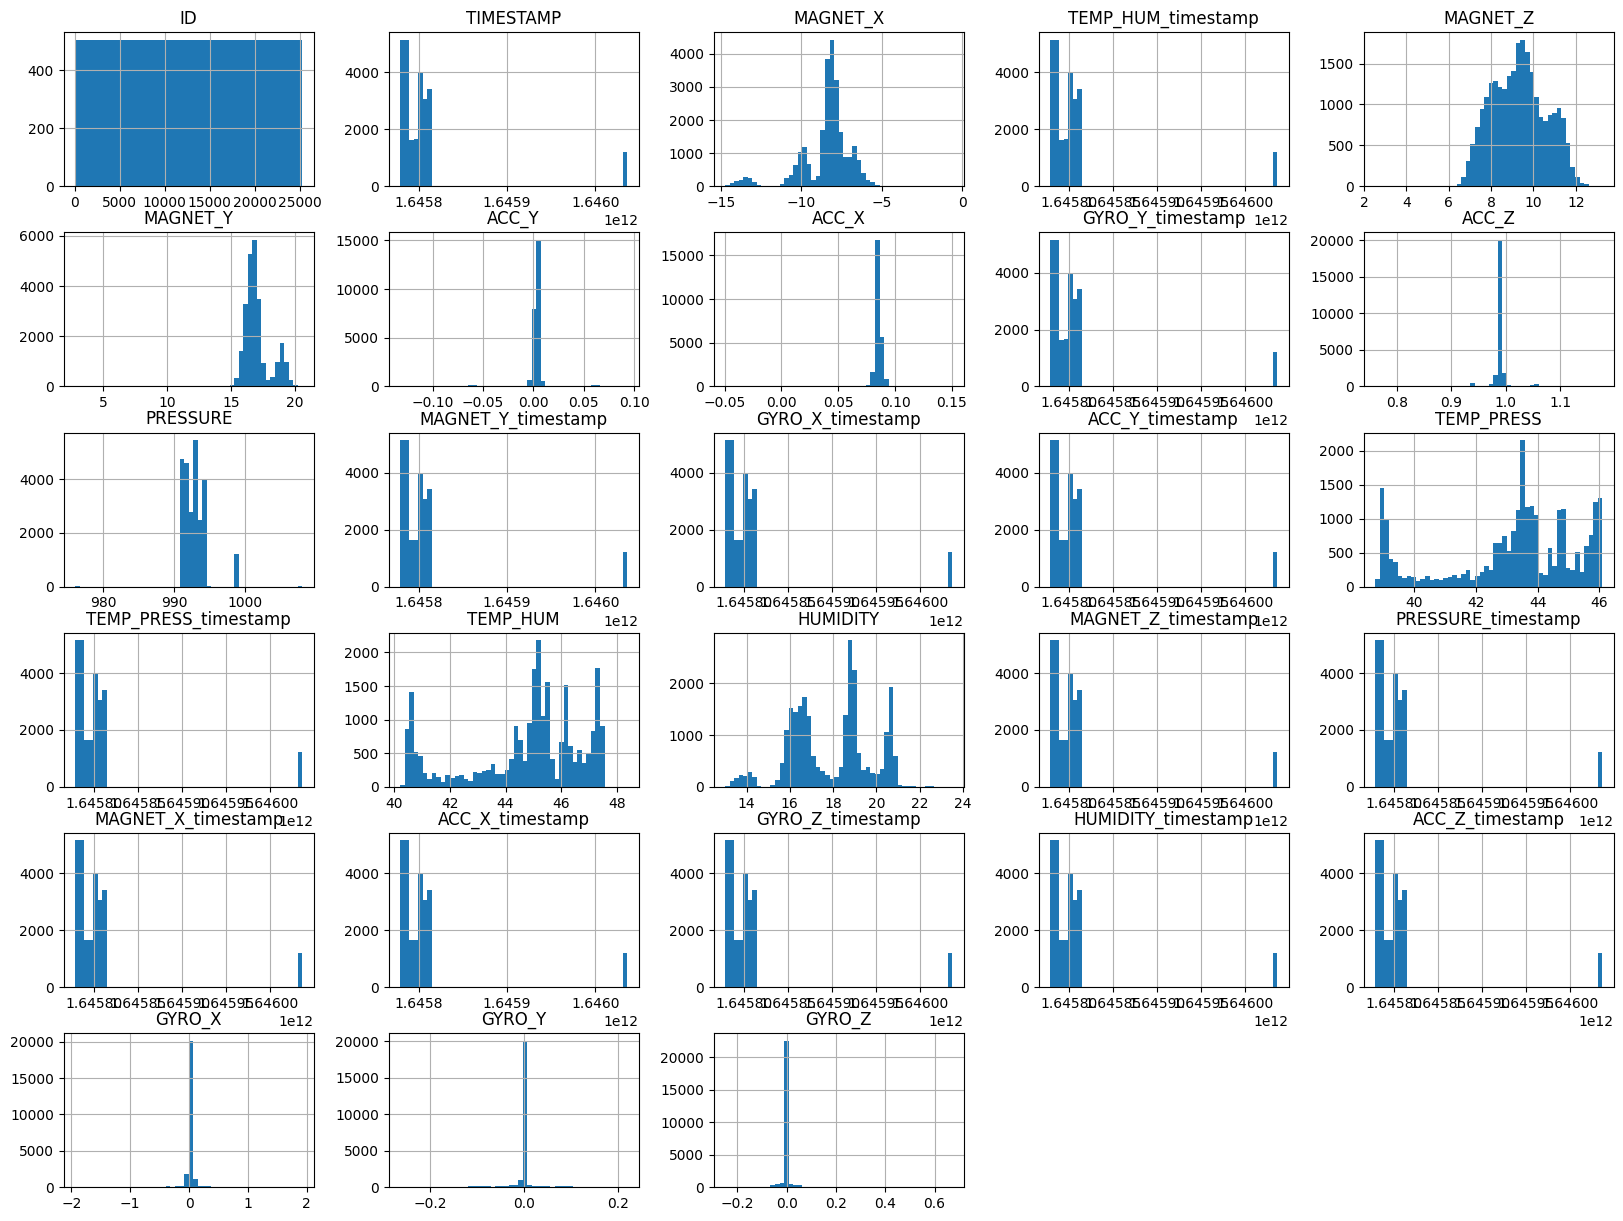

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(bins=50, figsize=(20,15))
plt.show()